# Optimizing Care Management Prioritization Under Capacity Constrains Using Healthcare Claims Data
##### Data Project 01/06

##### Data Source: Synthetics Medicare claims data released by the Centers for Medicare & Medicaid Services (CMS), including Beneficiary Summary, Inpatient and Outpatient claims files. 
##### The dataset was selected since its structure closely mirrors real-world payer claims data, enabling patient level aggregation of demographics, chronic conditions, healthcare utilization, and expenditures relevant to care management decision-making.

##### The goal of this project is to develop a capacity-aware patient prioritization framework for care management teams oprating under limited resources.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv('CMS_Beneficiary_Summary_File_Sample.csv', encoding='latin1')

In [4]:
df_in = pd.read_csv('CMS_Inpatient_Claims_Sample.csv', encoding='latin1')

In [5]:
df_out = pd.read_csv('CMS_Outpatient_Claims_Sample.csv', encoding='latin1')

<ipython-input-5-7694bc2c6fc3>:1: DtypeWarning: Columns (21,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_out = pd.read_csv('CMS_Outpatient_Claims_Sample.csv', encoding='latin1')


In [6]:
df

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,000002F7E0A96C32,19190701,NaN,2,2,0,5,400,4,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00001C24EE7B06AC,19360501,NaN,1,1,0,11,530,12,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,720.0,370.0,0.0
2,000072CF62193213,19310401,NaN,2,1,0,34,120,12,12,...,2,0.0,0.0,0.0,850.0,150.0,0.0,0.0,0.0,0.0
3,0000DCD33779ED8A,19420501,NaN,2,2,0,11,190,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0
4,0000F1EB530967F3,19350401,NaN,2,1,0,23,720,12,12,...,1,4000.0,1024.0,0.0,20.0,0.0,0.0,4840.0,1260.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116370,FFFD8472E348E5A5,19320501,NaN,1,1,0,50,160,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116371,FFFDAE0529142D0C,19330601,NaN,1,1,0,36,310,12,12,...,2,10000.0,1024.0,0.0,630.0,390.0,0.0,1740.0,710.0,0.0
116372,FFFDE6371A8EAF51,19401101,NaN,2,1,0,5,200,12,12,...,2,0.0,0.0,0.0,370.0,100.0,0.0,800.0,230.0,0.0
116373,FFFDF515B7CD464E,19261101,NaN,1,1,0,5,510,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,180.0,60.0,0.0


### Data filtering
##### Consider enrollment months, medical utilization. Remove death patient if any.

In [7]:
# Mark patients having full enrollment (enrollment month count>=12, due to different plan type)
cols = ['BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM']
df['Enrollment Month'] = df[cols].sum(axis=1)
df['Full Enrollment'] = np.where(df['Enrollment Month'] >= 12,1,0)

In [8]:
# Remove patients who are not considered as full enrollment and/or have records in death flag
df = df[df['BENE_DEATH_DT'].isna() &(df['Full Enrollment'] == 1)]

In [9]:
df

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,Enrollment Month,Full Enrollment
1,00001C24EE7B06AC,19360501,NaN,1,1,0,11,530,12,0,...,0.0,0.0,0.0,0.0,0.0,720.0,370.0,0.0,23,1
2,000072CF62193213,19310401,NaN,2,1,0,34,120,12,12,...,0.0,0.0,850.0,150.0,0.0,0.0,0.0,0.0,36,1
4,0000F1EB530967F3,19350401,NaN,2,1,0,23,720,12,12,...,1024.0,0.0,20.0,0.0,0.0,4840.0,1260.0,0.0,24,1
5,0001B495F55E2DFA,19410801,NaN,2,1,0,34,170,12,12,...,0.0,0.0,0.0,0.0,0.0,2370.0,690.0,50.0,24,1
6,00028CFDA8612B87,19431001,NaN,2,1,0,14,740,12,12,...,0.0,0.0,0.0,0.0,0.0,940.0,110.0,70.0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116370,FFFD8472E348E5A5,19320501,NaN,1,1,0,50,160,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,1
116371,FFFDAE0529142D0C,19330601,NaN,1,1,0,36,310,12,12,...,1024.0,0.0,630.0,390.0,0.0,1740.0,710.0,0.0,24,1
116372,FFFDE6371A8EAF51,19401101,NaN,2,1,0,5,200,12,12,...,0.0,0.0,370.0,100.0,0.0,800.0,230.0,0.0,36,1
116373,FFFDF515B7CD464E,19261101,NaN,1,1,0,5,510,12,12,...,0.0,0.0,0.0,0.0,0.0,180.0,60.0,0.0,36,1


In [10]:
# Look up inpatient/ outpatient records for all individuals. Add two addtional columns to df
in_counts = (df_in.groupby('DESYNPUF_ID')['CLM_ID'].nunique().reset_index().rename(columns={'CLM_ID': 'Inpatient record'}))
out_counts = (df_out.groupby('DESYNPUF_ID')['CLM_ID'].nunique().reset_index().rename(columns={'CLM_ID': 'Outpatient record'}))

In [11]:
df = df.merge(in_counts, on='DESYNPUF_ID', how='left')
df = df.merge(out_counts, on='DESYNPUF_ID', how='left')

In [12]:
df[['Outpatient record', 'Inpatient record']] = (df[['Outpatient record', 'Inpatient record']].fillna(0).astype(int))

In [13]:
df[['Outpatient record', 'Inpatient record']].describe()

,Outpatient record,Inpatient record
count,108456.000000,108456.000000
mean,7.053819,0.599331
std,8.014268,1.120675
min,0.000000,0.000000
25%,0.000000,0.000000
50%,4.000000,0.000000
75%,11.000000,1.000000
max,56.000000,12.000000


### Demographics Sanity Check
##### Group patients by age, clean up demographic data

In [14]:
# Calculate patients' age by DOB. Group by age.
df['BENE_BIRTH_DT'] = pd.to_datetime(df['BENE_BIRTH_DT'], format='%Y%m%d', errors='coerce')
ref_date = pd.Timestamp('2008-12-31')

df['Age'] = ((ref_date - df['BENE_BIRTH_DT']).dt.days // 365)

In [15]:
df['Age Group'] = pd.cut(df['Age'], bins=[0, 17, 34, 49, 64, 74, 84, 200],
    labels=['0–17', '18–34', '35–49', '50–64', '65–74', '75–84', '85+'],
    right=True, include_lowest=True)

In [16]:
df.columns

Index(['DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE', 'BENE_COUNTY_CD',
       'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
       'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR',
       'Enrollment Month', 'Full Enrollment', 'Inpatient record',
       'Outpatient record', 'Age', 'Age Group'],
      dtype='object')

In [17]:
# Rename columns
df.rename(columns={
        'BENE_BIRTH_DT': 'DOB',
        'BENE_SEX_IDENT_CD': 'Gender',
        'BENE_RACE_CD': 'Race',
        'BENE_ESRD_IND': 'Renal Disease Indicator',
        'SP_STATE_CODE': 'State',
        'BENE_COUNTY_CD': 'County',
        'SP_ALZHDMTA': 'Alzheimer_CC',
        'SP_CHF': 'Heart Failure_CC',
        'SP_CHRNKIDN': 'Kidney_CC',
        'SP_CNCR': 'Cancer_CC',
        'SP_COPD': 'Pulmonary_CC',
        'SP_DEPRESSN': 'Depression_CC',
        'SP_DIABETES': 'Diabetes_CC',
        'SP_ISCHMCHT': 'Ischemic Heart_CC',
        'SP_OSTEOPRS': 'Osteoporosis_CC',
        'SP_RA_OA': 'Arthritis_CC',
        'SP_STRKETIA':'Stroke_CC'},inplace=True)

In [18]:
# Recode from numeric values to descriptive label
df['Gender'] = df['Gender'].replace({
    1: 'Male',
    2: 'Female'})
df['Race'] = df['Race'].replace({
    1: 'White',
    2: 'Black',
    3: 'Others',
    5: 'Hispanic'})
df['Renal Disease Indicator'] = df['Renal Disease Indicator'].replace({
    'Y': 'Yes',
    '0': 'No'})
df['State'] = df['State'].replace({
    1: 'AL', 2: 'AK', 3: 'AZ', 4: 'AR', 5: 'CA', 6: 'CO', 7: 'CT', 8: 'DE', 9: 'DC', 10: 'FL',
    11: 'GA', 12: 'HI', 13: 'ID', 14: 'IL', 15: 'IN', 16: 'IA', 17: 'KS', 18: 'KY', 19: 'LA', 20: 'ME',
    21: 'MD', 22: 'MA', 23: 'MI', 24: 'MN', 25: 'MS', 26: 'MO', 27: 'MT', 28: 'NE', 29: 'NV', 30: 'NH',
    31: 'NJ', 32: 'NM', 33: 'NY', 34: 'NC', 35: 'ND', 36: 'OH', 37: 'OK', 38: 'OR', 39: 'PA',
    41: 'RI', 42: 'SC', 43: 'SD', 44: 'TN', 45: 'TX', 46: 'UT', 47: 'VT', 49: 'VA', 50: 'WA', 51: 'WV',
    52: 'WI', 53: 'WY', 54: 'Others'})

cc_cols = [
    "Alzheimer_CC", "Heart Failure_CC", "Kidney_CC", "Cancer_CC", "Pulmonary_CC", "Depression_CC",
    "Diabetes_CC", "Ischemic Heart_CC", "Osteoporosis_CC", "Arthritis_CC", "Stroke_CC"]
df[cc_cols] = df[cc_cols].replace({1: "Yes", 2: "No"})

In [19]:
df['Total record'] = (df['Inpatient record'] + df['Outpatient record'])
df = df.sort_values(by='Total record', ascending=False)

In [20]:
df

,DESYNPUF_ID,DOB,BENE_DEATH_DT,Gender,Race,Renal Disease Indicator,State,County,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,Enrollment Month,Full Enrollment,Inpatient record,Outpatient record,Age,Age Group,Total record
51763,7A04065D5D988B9A,1958-02-01,NaN,Female,Others,Yes,TX,530,12,6,...,16730.0,4300.0,0.0,18,1,8,52,50,50–64,60
87940,CFC9A12049F9DCAF,1936-04-01,NaN,Male,White,No,AR,450,12,12,...,310.0,230.0,0.0,24,1,1,56,72,65–74,57
82056,C20705AE6D5F1E1D,1939-04-01,NaN,Male,White,Yes,NJ,160,12,12,...,12560.0,3870.0,0.0,36,1,7,49,69,65–74,56
95932,E28940DEDAC165A9,1926-06-01,NaN,Female,White,Yes,IL,250,12,12,...,8760.0,2470.0,200.0,36,1,4,51,82,75–84,55
100005,EC2D9425FC4B1BA0,1961-06-01,NaN,Female,Black,Yes,IN,810,12,12,...,9510.0,1730.0,600.0,48,1,3,52,47,35–49,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53144,7D4B347B7F794F5E,1935-12-01,NaN,Male,White,Yes,KS,70,12,12,...,340.0,50.0,0.0,36,1,0,0,73,65–74,0
19445,2E29AF42C5137A1F,1951-08-01,NaN,Male,White,No,OH,290,12,12,...,0.0,0.0,0.0,48,1,0,0,57,50–64,0
19442,2E27A4B8A9D0BFCF,1939-01-01,NaN,Male,White,No,GA,190,12,0,...,0.0,0.0,0.0,24,1,0,0,70,65–74,0
84941,C8BE14D035CC6F47,1944-09-01,NaN,Male,White,No,LA,390,12,0,...,0.0,0.0,0.0,12,1,0,0,64,50–64,0


### Utilization Engineering
##### Inpatient utilization - Count of hospitalization, Sum & Average length of stay

In [21]:
df_in['CLM_ADMSN_DT'] = pd.to_datetime(df_in['CLM_ADMSN_DT'], format='%Y%m%d', errors='coerce')
df_in['NCH_BENE_DSCHRG_DT'] = pd.to_datetime(df_in['NCH_BENE_DSCHRG_DT'], format='%Y%m%d', errors='coerce')

In [22]:
df_in['Length_of_stay'] = (df_in['NCH_BENE_DSCHRG_DT'] - df_in['CLM_ADMSN_DT']).dt.days

In [23]:
df_in['Length_of_stay'].describe()

count    66514.000000
mean         5.704483
std          5.736845
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         35.000000
Name: Length_of_stay, dtype: float64

In [24]:
inpatient = (df_in.groupby('DESYNPUF_ID').agg(Inpatient_claims=('CLM_ID', 'nunique'), Avg_inpatient_LOS=('Length_of_stay', 'mean'))
    .reset_index())

In [25]:
inpatient['Inpatient_claims'] = inpatient['Inpatient_claims'].astype(int)
inpatient['Avg_inpatient_LOS'] = inpatient['Avg_inpatient_LOS'].round(2)

In [26]:
df = df.merge(inpatient, on='DESYNPUF_ID', how='left')

df[['Inpatient_claims']] = df[['Inpatient_claims']].fillna(0).astype(int)

In [27]:
df[['Inpatient_claims', 'Avg_inpatient_LOS']].describe()

,Inpatient_claims,Avg_inpatient_LOS
count,108456.000000,36529.000000
mean,0.599331,5.433514
std,1.120675,4.695614
min,0.000000,0.000000
25%,0.000000,2.670000
50%,0.000000,4.000000
75%,1.000000,7.000000
max,12.000000,35.000000


##### Outpatient utilization - Count of visit

In [28]:
outpatient = (df_out.groupby('DESYNPUF_ID')['CLM_ID'].nunique().reset_index().rename(columns={'CLM_ID': 'Outpatient_claims'}))

In [29]:
df = df.merge(outpatient, on='DESYNPUF_ID', how='left')

In [30]:
# fill 0 if no outpatient visit record
df['Outpatient_claims'] = df['Outpatient_claims'].fillna(0).astype(int)

In [31]:
df['Outpatient_claims'].describe()

count    108456.000000
mean          7.053819
std           8.014268
min           0.000000
25%           0.000000
50%           4.000000
75%          11.000000
max          56.000000
Name: Outpatient_claims, dtype: float64

In [32]:
df

,DESYNPUF_ID,DOB,BENE_DEATH_DT,Gender,Race,Renal Disease Indicator,State,County,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,Enrollment Month,Full Enrollment,Inpatient record,Outpatient record,Age,Age Group,Total record,Inpatient_claims,Avg_inpatient_LOS,Outpatient_claims
0,7A04065D5D988B9A,1958-02-01,NaN,Female,Others,Yes,TX,530,12,6,...,18,1,8,52,50,50–64,60,8,7.00,52
1,CFC9A12049F9DCAF,1936-04-01,NaN,Male,White,No,AR,450,12,12,...,24,1,1,56,72,65–74,57,1,17.00,56
2,C20705AE6D5F1E1D,1939-04-01,NaN,Male,White,Yes,NJ,160,12,12,...,36,1,7,49,69,65–74,56,7,4.86,49
3,E28940DEDAC165A9,1926-06-01,NaN,Female,White,Yes,IL,250,12,12,...,36,1,4,51,82,75–84,55,4,3.75,51
4,EC2D9425FC4B1BA0,1961-06-01,NaN,Female,Black,Yes,IN,810,12,12,...,48,1,3,52,47,35–49,55,3,4.00,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108451,7D4B347B7F794F5E,1935-12-01,NaN,Male,White,Yes,KS,70,12,12,...,36,1,0,0,73,65–74,0,0,NaN,0
108452,2E29AF42C5137A1F,1951-08-01,NaN,Male,White,No,OH,290,12,12,...,48,1,0,0,57,50–64,0,0,NaN,0
108453,2E27A4B8A9D0BFCF,1939-01-01,NaN,Male,White,No,GA,190,12,0,...,24,1,0,0,70,65–74,0,0,NaN,0
108454,C8BE14D035CC6F47,1944-09-01,NaN,Male,White,No,LA,390,12,0,...,12,1,0,0,64,50–64,0,0,NaN,0


##### Cost Analysis

In [33]:
# Inpatient vs Outpatient cost
df_out['CLM_PMT_AMT'] = pd.to_numeric(df_out['CLM_PMT_AMT'], errors='coerce')
df_in['CLM_PMT_AMT']  = pd.to_numeric(df_in['CLM_PMT_AMT'],  errors='coerce')

In [34]:
out_cost = (df_out.groupby('DESYNPUF_ID')['CLM_PMT_AMT'].sum(min_count=1)
    .reset_index().rename(columns={'CLM_PMT_AMT': 'Outpatient_spending'}))
in_cost = (df_in.groupby('DESYNPUF_ID')['CLM_PMT_AMT'].sum(min_count=1)
    .reset_index().rename(columns={'CLM_PMT_AMT': 'Inpatient_spending'}))

In [35]:
df = df.merge(out_cost, on='DESYNPUF_ID', how='left')
df = df.merge(in_cost,  on='DESYNPUF_ID', how='left')

df[['Outpatient_spending', 'Inpatient_spending']] = (df[['Outpatient_spending', 'Inpatient_spending']].fillna(0))
df['Total_spending'] = df['Outpatient_spending'] + df['Inpatient_spending']

In [36]:
df[['Outpatient_spending', 'Inpatient_spending', 'Total_spending']].describe()

,Outpatient_spending,Inpatient_spending,Total_spending
count,108456.000000,108456.000000,108456.000000
mean,2022.004315,5703.316460,7725.320775
std,5366.301429,13210.919132,15590.886583
min,-100.000000,-8000.000000,-7130.000000
25%,0.000000,0.000000,10.000000
50%,650.000000,0.000000,1420.000000
75%,2380.000000,6000.000000,8560.000000
max,117920.000000,220000.000000,243440.000000


In [37]:
df = df.sort_values(by='Total_spending', ascending=False)
df

,DESYNPUF_ID,DOB,BENE_DEATH_DT,Gender,Race,Renal Disease Indicator,State,County,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,Outpatient record,Age,Age Group,Total record,Inpatient_claims,Avg_inpatient_LOS,Outpatient_claims,Outpatient_spending,Inpatient_spending,Total_spending
16,61BCF714C7D249A2,1923-08-01,NaN,Female,White,Yes,IA,940,12,12,...,41,85,85+,51,10,6.20,41,67440.0,176000.0,243440.0
6923,C6D27E25855D1A3C,1930-07-01,NaN,Female,Black,Yes,MD,30,12,12,...,14,78,75–84,23,9,14.11,14,14670.0,220000.0,234670.0
615,FF25743A4006C021,1940-03-01,NaN,Female,White,Yes,NC,580,12,12,...,31,68,65–74,38,7,14.12,31,56880.0,169000.0,225880.0
271,EC777444809FD26E,1949-05-01,NaN,Female,White,Yes,CA,400,12,12,...,34,59,50–64,41,7,8.14,34,67030.0,157000.0,224030.0
35388,437A65596B56D18B,1958-02-01,NaN,Female,White,No,NY,331,12,12,...,4,50,50–64,10,6,18.14,4,2540.0,216000.0,218540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67441,F129151DFA3FAA46,1936-10-01,NaN,Female,White,No,TX,711,12,12,...,2,72,65–74,2,0,NaN,2,-50.0,0.0,-50.0
72361,253D8AF790C96078,1937-10-01,NaN,Male,White,No,CO,380,12,12,...,2,71,65–74,2,0,NaN,2,-60.0,0.0,-60.0
75056,162627AC7A9ED9BE,1979-12-01,NaN,Male,White,No,CA,470,12,12,...,1,29,18–34,1,0,NaN,1,-60.0,0.0,-60.0
73737,BD40DFA18EDFAED0,1922-01-01,NaN,Female,Others,No,HI,20,12,12,...,1,87,85+,1,0,NaN,1,-80.0,0.0,-80.0


In [38]:
# Most expensive category?
OUTCOMES = ['Inpatient_spending', 'Outpatient_spending', 'Total_spending']

def summarize_categories(df, cat_cols, outcomes=OUTCOMES):
    """
    Returns a long-form summary table:
    variable | category | n | outcome_mean | outcome_median
    """
    all_results = []
    for col in cat_cols:
        if col not in df.columns:
            continue
        tmp = (
            df.groupby(col)[outcomes]
            .agg(['count', 'mean', 'median'])
        )
        tmp.columns = [f"{o}_{stat}" for o, stat in tmp.columns]
        tmp = tmp.reset_index().rename(columns={col: 'category'})

        tmp.insert(0, 'variable', col)

        if 'Total_spending_count' in tmp.columns:
            tmp = tmp.rename(columns={'Total_spending_count': 'n'})
        else:
            first_count = [c for c in tmp.columns if c.endswith('_count')][0]
            tmp = tmp.rename(columns={first_count: 'n'})

        all_results.append(tmp)

    if not all_results:
        return pd.DataFrame()

    result = pd.concat(all_results, ignore_index=True)

    keep_cols = (
        ['variable', 'category', 'n'] +
        [f'{o}_mean' for o in outcomes] +
        [f'{o}_median' for o in outcomes]
    )
    keep_cols = [c for c in keep_cols if c in result.columns]
    result = result[keep_cols]

    return result


# Possible categories:
chronic_cols = [
    'Alzheimer_CC','Heart Failure_CC','Kidney_CC','Cancer_CC','Pulmonary_CC','Depression_CC','Diabetes_CC','Ischemic Heart_CC',
    'Osteoporosis_CC', 'Arthritis_CC','Stroke_CC']

cat_cols = [
    'Age Group','Gender','Race','Renal Disease Indicator','State',] + chronic_cols

summary_all = summarize_categories(df, cat_cols)

top_by_var = (
    summary_all
    .sort_values(['variable', 'Total_spending_mean'], ascending=[True, False])
    .groupby('variable')
    .head(5)
)

summary_all, top_by_var

<ipython-input-38-cc9b2d5d8c15>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[outcomes]


(           variable category       n  Inpatient_spending_mean  \
 0         Age Group     0–17       0                      NaN   
 1         Age Group    18–34    1512              5592.533069   
 2         Age Group    35–49    5389              5930.486176   
 3         Age Group    50–64   10532              6134.260349   
 4         Age Group    65–74   45327              4734.281554   
 ..              ...      ...     ...                      ...   
 84  Osteoporosis_CC      Yes   19681              9851.652863   
 85     Arthritis_CC       No   91121              4540.973980   
 86     Arthritis_CC      Yes   17335             11813.141044   
 87        Stroke_CC       No  103308              4985.426201   
 88        Stroke_CC      Yes    5148             20109.650350   
 
     Outpatient_spending_mean  Total_spending_mean  Inpatient_spending_median  \
 0                        NaN                  NaN                        NaN   
 1                2166.256614          7758.

In [230]:
# who spend the most?
best_category_each_var = (
    summary_all.sort_values('Total_spending_mean', ascending=False)
    .groupby('variable')
    .head(1)
)
best_category_each_var

,variable,category,n,Inpatient_spending_mean,Outpatient_spending_mean,Total_spending_mean,Inpatient_spending_median,Outpatient_spending_median,Total_spending_median
14,Renal Disease Indicator,Yes,8027,18147.933225,8560.165691,26708.098916,9000.0,2770.0,13690.0
88,Stroke_CC,Yes,5148,20109.650350,5262.278555,25371.928904,12000.0,2435.0,15295.0
72,Kidney_CC,Yes,18334,17271.384313,5604.719647,22876.103960,10000.0,2630.0,13375.0
76,Pulmonary_CC,Yes,15405,17413.655307,4574.866602,21988.521908,10000.0,2500.0,13080.0
74,Cancer_CC,Yes,7191,14753.537756,4326.787651,19080.325407,7000.0,2850.0,11020.0
70,Heart Failure_CC,Yes,32632,12559.767100,3981.553383,16541.320483,5000.0,2030.0,8530.0
68,Alzheimer_CC,Yes,21909,12785.252636,3730.036058,16515.288694,5000.0,2010.0,8570.0
86,Arthritis_CC,Yes,17335,11813.141044,3623.931353,15437.072397,5000.0,2190.0,8000.0
78,Depression_CC,Yes,24381,11478.588245,3692.287847,15170.876092,4000.0,2120.0,7580.0
80,Diabetes_CC,Yes,43300,10594.431640,3676.055889,14270.487529,4000.0,1900.0,6720.0


In [39]:
def plot_spending_by_category(df, category_col,
    inpatient_col='Inpatient_spending',
    outpatient_col='Outpatient_spending',
    agg='mean'
):
    """
    Draws a grouped bar chart:
    x-axis: sub-categories of category_col
    y-axis: spending
    bars: inpatient vs outpatient
    """
    summary = (df.groupby(category_col)[[inpatient_col, outpatient_col]].agg(agg).reset_index()
        .sort_values(by=[inpatient_col, outpatient_col], ascending=False))
    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, summary[inpatient_col], width, label='Inpatient',)
    plt.bar(x + width/2, summary[outpatient_col], width, label='Outpatient',)

    plt.xticks(x, summary[category_col], rotation=45, ha='right')
    plt.ylabel('Spending amount')
    plt.title(f'{agg.capitalize()} spending by {category_col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

<ipython-input-39-215643519543>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (df.groupby(category_col)[[inpatient_col, outpatient_col]].agg(agg).reset_index()


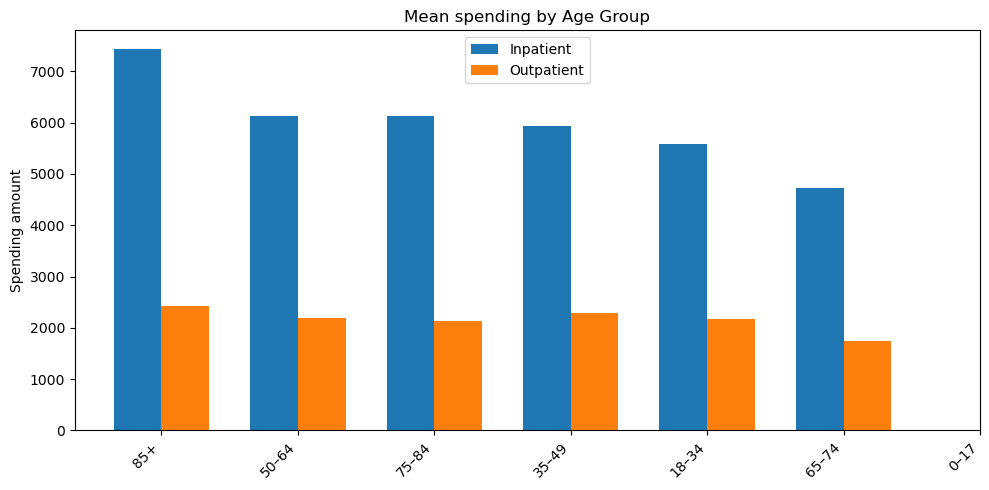

In [40]:
plot_spending_by_category(df, 'Age Group')

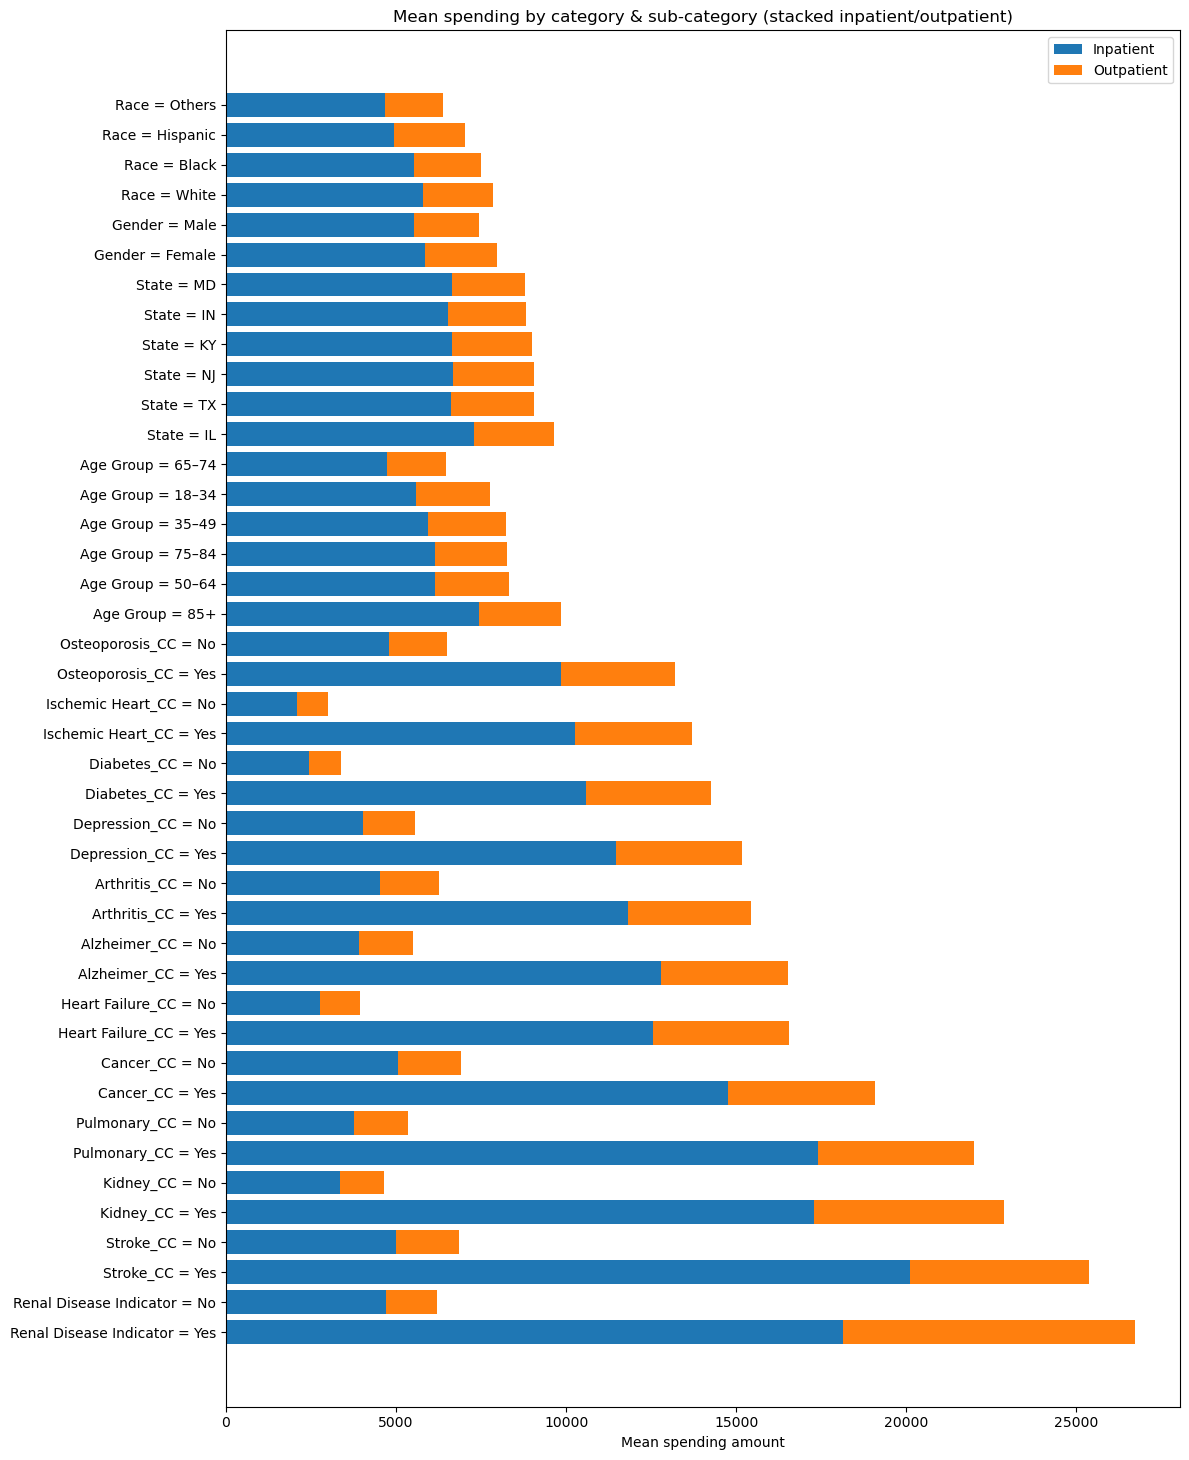

In [41]:
def one_chart_all_categories(
    df,
    cat_cols,
    inpatient_col='Inpatient_spending',
    outpatient_col='Outpatient_spending',
    agg='mean',          # 'mean' or 'median'
    top_n=6,             # keep top N sub-categories per category (prevents unreadable charts)
    dropna_level=False,  # keep NaN levels as 'Missing' if False
):
    # --- build aggregated table across all categories ---
    pieces = []

    for c in cat_cols:
        if c not in df.columns:
            continue

        tmp = df[[c, inpatient_col, outpatient_col]].copy()
        if not dropna_level:
            tmp[c] = tmp[c].astype('object').where(tmp[c].notna(), 'Missing')

        g = (
            tmp.groupby(c)[[inpatient_col, outpatient_col]]
            .agg(agg)
            .reset_index()
            .rename(columns={c: 'level'})
        )

        g['category'] = c
        g['total'] = g[inpatient_col] + g[outpatient_col]

        # keep only top N levels by total spending (within each category)
        g = g.sort_values('total', ascending=False).head(top_n)

        pieces.append(g)

    plot_df = pd.concat(pieces, ignore_index=True)

    # label each bar as "Category = Level"
    plot_df['label'] = plot_df['category'].astype(str) + ' = ' + plot_df['level'].astype(str)

    # order bars: within each category by total desc; and categories by their max total desc
    cat_order = (
        plot_df.groupby('category')['total']
        .max()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    plot_df['category'] = pd.Categorical(plot_df['category'], categories=cat_order, ordered=True)
    plot_df = plot_df.sort_values(['category', 'total'], ascending=[True, False])

    # --- plot: one big horizontal stacked bar chart ---
    y = range(len(plot_df))
    inpatient = plot_df[inpatient_col].fillna(0).values
    outpatient = plot_df[outpatient_col].fillna(0).values

    fig_h = max(6, 0.35 * len(plot_df))  # auto height for readability
    plt.figure(figsize=(12, fig_h))

    plt.barh(y, inpatient, label='Inpatient')
    plt.barh(y, outpatient, left=inpatient, label='Outpatient')

    plt.yticks(list(y), plot_df['label'])
    plt.xlabel(f'{agg.capitalize()} spending amount')
    plt.title(f'{agg.capitalize()} spending by category & sub-category (stacked inpatient/outpatient)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return plot_df  # returns the summary behind the chart (useful for debugging)

# run it
summary_used = one_chart_all_categories(df, cat_cols, agg='mean', top_n=6)


In [46]:
cc_cols = [
    "Alzheimer_CC", "Heart Failure_CC", "Kidney_CC", "Cancer_CC", "Pulmonary_CC", "Depression_CC",
    "Diabetes_CC", "Ischemic Heart_CC", "Osteoporosis_CC", "Arthritis_CC", "Stroke_CC"]
df[cc_cols] = df[cc_cols].replace({"Yes": 1, "No": 0})

<ipython-input-46-f8eb3ed48578>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cc_cols] = df[cc_cols].replace({"Yes": 1, "No": 0})


In [55]:
# Chronic count includes all chronic diseases labeled for each patient
df['Chronic_count'] = df[chronic_cols].sum(axis=1)
df['log_total_spending'] = np.log1p(df['Total_spending'])

In [56]:
df

,DESYNPUF_ID,DOB,BENE_DEATH_DT,Gender,Race,Renal Disease Indicator,State,County,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,Age Group,Total record,Inpatient_claims,Avg_inpatient_LOS,Outpatient_claims,Outpatient_spending,Inpatient_spending,Total_spending,Chronic_count,log_total_spending
16,61BCF714C7D249A2,1923-08-01,NaN,Female,White,Yes,IA,940,12,12,...,85+,51,10,6.20,41,67440.0,176000.0,243440.0,9,12.402630
6923,C6D27E25855D1A3C,1930-07-01,NaN,Female,Black,Yes,MD,30,12,12,...,75–84,23,9,14.11,14,14670.0,220000.0,234670.0,9,12.365940
615,FF25743A4006C021,1940-03-01,NaN,Female,White,Yes,NC,580,12,12,...,65–74,38,7,14.12,31,56880.0,169000.0,225880.0,7,12.327764
271,EC777444809FD26E,1949-05-01,NaN,Female,White,Yes,CA,400,12,12,...,50–64,41,7,8.14,34,67030.0,157000.0,224030.0,7,12.319540
35388,437A65596B56D18B,1958-02-01,NaN,Female,White,No,NY,331,12,12,...,50–64,10,6,18.14,4,2540.0,216000.0,218540.0,6,12.294729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67441,F129151DFA3FAA46,1936-10-01,NaN,Female,White,No,TX,711,12,12,...,65–74,2,0,NaN,2,-50.0,0.0,-50.0,2,NaN
72361,253D8AF790C96078,1937-10-01,NaN,Male,White,No,CO,380,12,12,...,65–74,2,0,NaN,2,-60.0,0.0,-60.0,0,NaN
75056,162627AC7A9ED9BE,1979-12-01,NaN,Male,White,No,CA,470,12,12,...,18–34,1,0,NaN,1,-60.0,0.0,-60.0,1,NaN
73737,BD40DFA18EDFAED0,1922-01-01,NaN,Female,Others,No,HI,20,12,12,...,85+,1,0,NaN,1,-80.0,0.0,-80.0,0,NaN


In [57]:
df["Chronic_count"] = pd.to_numeric(df["Chronic_count"], errors="coerce")

In [58]:
model = smf.ols(
    formula="""
        log_total_spending ~
        Age +
        Gender +
        Race +
        Chronic_count +
        Inpatient_claims +
        Outpatient_claims
    """,
    data=df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_total_spending   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                 1.787e+04
Date:                Thu, 08 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:21:25   Log-Likelihood:            -2.5323e+05
No. Observations:              108421   AIC:                         5.065e+05
Df Residuals:                  108412   BIC:                         5.066e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.7453      0.049     55.902      0.000       2.649       2.842
Gender[T.Male]       -0.0994      0.015     -6.448      0.000      -0.130      -0.069
Race[T.Hispanic]     -0.1038      0.055     -1.879      0.060      -0.212       0.004
Race[T.Others]       -0.1422      0.044     -3.229      0.001      -0.229      -0.056
Race[T.White]         0.2941      0.025     11.687      0.000       0.245       0.343
Age                   0.0036      0.001      5.934      0.000       0.002       0.005
Chronic_count         0.4346      0.004     99.799      0.000       0.426       0.443
Inpatient_claims      0.7922      0.008     94.640      0.000       0.776       0.809
Outpatient_claims     0.1839      0.001    154.829      0.000       0.182       0.186
==============================================================================
Omnibus:                    21607.705   Durbin-Watson:                   0.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4538.424
Skew:                          -0.125   Prob(JB):                         0.00
Kurtosis:                       2.029   Cond. No.                         600.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observation:
##### The model explains a large part of the variation in future healthcare spending: 𝑅^2 = 0.569, meaning more than half of the variation in log total spending is explained by the variables in the model.

##### Healthcare utilization is the strongest predictor of future spending: 
    - Outpatient visits have the largest effect (t ≈ 155).
    - Inpatient visits are also very strong (t ≈ 95).
    - Utilization variables are much more important than demographic factors.

##### Chronic condition count is strongly associated with higher future spending (with high t-statistic, t ≈ 100). This suggests that higher disease burden is linked to higher healthcare cost.

##### Age has a statistically significant but relatively small effect. Compared to utilization and chronic burden, age explains much less variation in spending. Gender and race effects are relatively small. Male patients have slightly lower spending than female patients, holding other factors constant. Race coefficients vary, but their effects are much smaller than utilization-related variables.

##### Residual diagnostics show non-normality, which is expected for healthcare cost data

##### Because healthcare spending is highly skewed, coefficient interpretation is less important than ranking performance.

##### Based on these results, utilization and chronic burden variables are used to build a prioritization strategy

##### The goal is to rank members under capacity constraints rather than predict exact spending amounts.

### Cost & Target
##### Why we need to do prioritization? We select patients who spend the most in historical data to consider prioritize provide intervention from the care management team, in order to maximize the efficiency and lower potential cost

In [59]:
# Rank and Calculate total cost by patient
df['Total_spending'].describe(percentiles = [.5,.9,.95,.99])

count    108456.000000
mean       7725.320775
std       15590.886583
min       -7130.000000
50%        1420.000000
90%       21730.000000
95%       35542.500000
99%       78335.000000
max      243440.000000
Name: Total_spending, dtype: float64

In [60]:
# Top X% cover how much of total cost?
def top_cost_share(df, cost_col="Total_spending", top_pct=0.05):
    s = df[cost_col].fillna(0)
    cutoff = s.quantile(1 - top_pct)
    share = s[s >= cutoff].sum() / s.sum() if s.sum() > 0 else np.nan
    return cutoff, share

cut5, share5 = top_cost_share(df, top_pct=0.05)
cut10, share10 = top_cost_share(df, top_pct=0.10)

print("Top 5% cutoff:", cut5, " Top 5% cost share:", share5)
print("Top 10% cutoff:", cut10, " Top 10% cost share:", share10)

Top 5% cutoff: 35542.5  Top 5% cost share: 0.4010463045507064
Top 10% cutoff: 21730.0  Top 10% cost share: 0.5796842825483702


### Observation:
##### Healthcare spending in this population is highly concentrated: the top 5% of beneficiaries account for approximately 40% of total spending, while the top 10% account for nearly 58%. This concentration motivates a capacity-constrained prioritization approach rather than uniform intervention.

### Capacity Simulation

In [61]:
df["priority_score"] = (df["Inpatient_claims"] * 3+ df["Outpatient_claims"] * 1)

In [62]:
def cost_capture_topk(df, score_col, cost_col="Total_spending", k=500):
    df_sorted = df.sort_values(score_col, ascending=False)
    topk_cost = df_sorted.head(k)[cost_col].sum()
    total_cost = df_sorted[cost_col].sum()
    return topk_cost / total_cost if total_cost > 0 else None

In [63]:
for k in [200, 500, 1000]:
    cap = cost_capture_topk(df, score_col="priority_score", k=k)
    print(f"Top-{k} cost capture: {cap:.3f}")

Top-200 cost capture: 0.025
Top-500 cost capture: 0.054
Top-1000 cost capture: 0.093


In [64]:
def random_cost_capture(df, cost_col="Total_spending", k=500, n_trials=50, seed=42):
    rng = np.random.default_rng(seed)
    total_cost = df[cost_col].sum()
    caps = []

    for _ in range(n_trials):
        sample = df.sample(n=min(k, len(df)), replace=False, random_state=rng.integers(0, 1e9))
        caps.append(sample[cost_col].sum() / total_cost)

    return np.mean(caps), np.std(caps)

for k in [200, 500, 1000]:
    prio = cost_capture_topk(df, "priority_score", k=k)
    rnd_mean, rnd_std = random_cost_capture(df, k=k)
    print(f"""
Top-{k}
  Priority-based capture: {prio:.3f}
  Random capture: {rnd_mean:.3f} ± {rnd_std:.3f}
""")


Top-200
  Priority-based capture: 0.025
  Random capture: 0.002 ± 0.000


Top-500
  Priority-based capture: 0.054
  Random capture: 0.005 ± 0.000


Top-1000
  Priority-based capture: 0.093
  Random capture: 0.009 ± 0.001



### Observation:
##### Using only utilization information, the prioritization captures around 5–9% of future cost for the top 0.5–1% of members. This is clearly better than random selection and indicates that utilization is a strong signal, although there is still room to improve the approach.

In [66]:
# Bring Avg_inpatient_LOS into model
df["priority_score_v2"] = (
    df["Inpatient_claims"] * 3
    + df["Avg_inpatient_LOS"] * 2
    + df["Outpatient_claims"] * 1
)

for k in [200, 500, 1000]:
    cap = cost_capture_topk(df, score_col="priority_score_v2", k=k)
    print(f"Top-{k} cost capture (v2): {cap:.3f}")

Top-200 cost capture (v2): 0.012
Top-500 cost capture (v2): 0.035
Top-1000 cost capture (v2): 0.074


### Observation:
##### While length of stay is associated with inpatient severity, directly including average LOS in a population-level prioritization score led to worse ranking performance. This is likely due to its conditional nature and limited coverage among members without inpatient admissions.

In [67]:
# Replace average LOS with a binary long-stay indicator.
# This aligns better with care management workflows, where prolonged hospitalizations are treated as severity signals rather than continuous predictors.

df["long_los_flag"] = (
    (df["Avg_inpatient_LOS"] >= 7) & (df["Inpatient_claims"] > 0)
).astype(int)

df["priority_score_v3"] = (
    df["Inpatient_claims"] * 3
    + df["long_los_flag"] * 2
    + df["Outpatient_claims"] * 1
)
for k in [200, 500, 1000]:
    cap = cost_capture_topk(df, score_col="priority_score_v3", k=k)
    print(f"Top-{k} cost capture (v2): {cap:.3f}")

Top-200 cost capture (v2): 0.026
Top-500 cost capture (v2): 0.055
Top-1000 cost capture (v2): 0.095


### Observation:
##### Replacing average length of stay with a binary long-stay indicator resulted in modest but consistent improvements in cost capture for larger capacity settings. This suggests that LOS provides incremental value as a severity signal when applied conditionally, without destabilizing population-level rankings.

In [69]:
N = len(df)
Ks = [100, 200, 500, 1000, 2000, 5000]

rows = []
for k in Ks:
    rows.append({
        "K": k,
        "capacity_pct": k / N,
        "capture_v1": cost_capture_topk(df, "priority_score", k=k),
        "capture_v3": cost_capture_topk(df, "priority_score_v3", k=k),})

cap_table = pd.DataFrame(rows)
cap_table

,K,capacity_pct,capture_v1,capture_v3
0,100,0.000922,0.014202,0.013996
1,200,0.001844,0.024903,0.025660
2,500,0.004610,0.054373,0.055225
3,1000,0.009220,0.092705,0.094620
4,2000,0.018441,0.148557,0.150558
5,5000,0.046102,0.260213,0.263790


In [70]:
def random_capture_mean(df, cost_col="Total_spending", k=500, n_trials=50, seed=42):
    rng = np.random.default_rng(seed)
    total_cost = df[cost_col].sum()
    caps = []
    for _ in range(n_trials):
        sample = df.sample(n=min(k, len(df)), replace=False, random_state=rng.integers(0, 1e9))
        caps.append(sample[cost_col].sum() / total_cost)
    return float(np.mean(caps))

cap_table["capture_random"] = cap_table["K"].apply(lambda k: random_capture_mean(df, k=k))
cap_table

,K,capacity_pct,capture_v1,capture_v3,capture_random
0,100,0.000922,0.014202,0.013996,0.000928
1,200,0.001844,0.024903,0.025660,0.001844
2,500,0.004610,0.054373,0.055225,0.004548
3,1000,0.009220,0.092705,0.094620,0.009228
4,2000,0.018441,0.148557,0.150558,0.018500
5,5000,0.046102,0.260213,0.263790,0.046187


### Conclusion:
##### Under capacity constraints, utilization-based prioritization performs much better than random selection. For example, selecting the top 0.46% of members captures about 5.5% of future healthcare spending, while random selection captures only about 0.45%. Adding a binary long-stay indicator provides small but consistent improvements at moderate to larger capacity levels, without changing the overall ranking pattern.